
# Example of High Gamma Filter

Below is a code sample for extracting high gamma power from a raw data file, followed by permutation cluster stats on that high gamma power data


### working version 12/1/23

### try gregs suggestion of using make_data_same to destroy the fixation cross

['c:\\Users\\jz421\\Desktop\\GlobalLocal', 'C:\\Users\\jz421\\Desktop\\GlobalLocal\\IEEG_Pipelines', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\python311.zip', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\DLLs', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg', '', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\L

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 178
filt channels before dropping bads: 178
outlier round 1 channels: ['RAMT8']
outlier round 2 channels: ['RAMT8', 'RPI16']
outlier round 2 channels: ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good': ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 175
filt channels after dropping bads: 175
Reading 0 ... 5983997  =      0.000 ...  2921.874 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus

100%|██████████| 448/448 [06:19<00:00,  1.18it/s]


Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
436 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 436 events and 7169 original

C:\Users\jz421\AppData\Local\Temp\ipykernel_2420\2799063238.py:125: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
436 matching events found
No baseline correction applied


100%|██████████| 436/436 [09:20<00:00,  1.29s/it]


HG_ev1 before crop_pad:  -1.5 2.0
HG_ev1 after crop_pad:  -1.0 1.5
Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_2420\2799063238.py:135: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_2420\2799063238.py:136: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_2420\2799063238.py:138: RuntimeWarning: Mean of empty slice
  HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_2420\2799063238.py:139: RuntimeWarning: Mean of empty slice
  HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


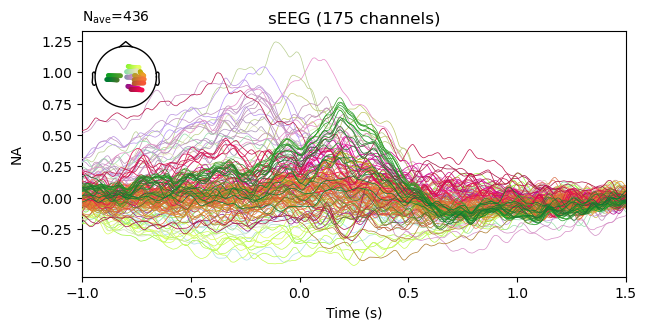

plotted non stimulus
Shape of HG_ev1._data: (436, 175, 2561)
Shape of HG_base._data: (448, 175, 1025)
Shape of sig1: (436, 175, 2561)
Shape of sig2: (448, 175, 1025)
Shape of sig3: (448, 175, 1026)
Shape of sig4: (448, 175, 1025)
Shape of sig5: (448, 175, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [7]:
###
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans, load_sig_chans
import matplotlib.pyplot as plt


def plot_HG_and_stats(sub, task, output_name, event=None, times=(-1, 1.5),
                      base_times=(-0.5, 0), LAB_root=None, channels=None,
                      full_trial_base=False):
    """
    Plot high gamma (HG) and statistics for a given subject and task using specified event.

    Parameters:
    - sub (str): The subject identifier.
    - task (str): The task identifier.
    - output_name (str): The name for the output files.
    - event (str, optional): Event name to process. Defaults to None.
    - times (tuple, optional): A tuple indicating the start and end times for processing. Defaults to (-1, 1.5).
    - base_times (tuple, optional): A tuple indicating the start and end base times for processing. Defaults to (-0.5, 0).
    - LAB_root (str, optional): The root directory for the lab. Will be determined based on OS if not provided. Defaults to None.
    - channels (list of strings, optional): The channels to plot and get stats for. Default is all channels.
    - full_trial_base (boolean): Whether to use the full trial as the baseline period. Default is False.
    This function will process the provided event for a given subject and task.
    High gamma (HG) will be computed, and statistics will be calculated and plotted.
    The results will be saved to output files.
    """
    pass

subjects = ['D0059', 'D0063', 'D0065', 'D0069', 'D0071']

# for sub in subjects:
sub = 'D0057'
task = 'GlobalLocal'
output_name = "Response_fixationCrossBase_1sec_mirror"
events = ["Response"]
times = (-1,1.5)
base_times = [-1,0]
LAB_root = None
channels = None
full_trial_base = False

if LAB_root is None:
    HOME = os.path.expanduser("~")
    if os.name == 'nt':  # windows
        LAB_root = os.path.join(HOME, "Box", "CoganLab")
    else:  # mac
        LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                "CoganLab")

layout = get_data(task, root=LAB_root)
filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                    extension='.edf', desc='clean', preload=False)
save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

good = crop_empty_data(filt)
# %%

print(f"good channels before dropping bads: {len(good.ch_names)}")
print(f"filt channels before dropping bads: {len(filt.ch_names)}")

good.info['bads'] = channel_outlier_marker(good, 3, 2)
print("Bad channels in 'good':", good.info['bads'])

filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
good.drop_channels(good.info['bads'])

print("Bad channels in 'good' after dropping once:", good.info['bads'])

print(f"good channels after dropping bads: {len(good.ch_names)}")
print(f"filt channels after dropping bads: {len(filt.ch_names)}")

good.load_data()

# If channels is None, use all channels
if channels is None:
    channels = good.ch_names
else:
    # Validate the provided channels
    invalid_channels = [ch for ch in channels if ch not in good.ch_names]
    if invalid_channels:
        raise ValueError(
            f"The following channels are not valid: {invalid_channels}")

    # Use only the specified channels
    good.pick_channels(channels)

ch_type = filt.get_channel_types(only_data_chs=True)[0]
good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

# Create a baseline EpochsTFR using the stimulus event

adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
trials = trial_ieeg(good, "Stimulus", adjusted_base_times, preload=True)
outliers_to_nan(trials, outliers=10)
HG_base = gamma.extract(trials, copy=False, n_jobs=1)
crop_pad(HG_base, "0.5s")

all_epochs_list = []

for event in events:
# Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
    times_adj = [times[0] - 0.5, times[1] + 0.5]
    trials = trial_ieeg(good, event, times_adj, preload=True,
                        reject_by_annotation=False)
    all_epochs_list.append(trials)

# Concatenate all trials
all_trials = mne.concatenate_epochs(all_epochs_list)

outliers_to_nan(all_trials, outliers=10)
HG_ev1 = gamma.extract(all_trials, copy=True, n_jobs=1)
print("HG_ev1 before crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)
crop_pad(HG_ev1, "0.5s")
print("HG_ev1 after crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)

HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')

HG_base.decimate(2)
HG_ev1.decimate(2)

HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)

HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0)) #axis=0 should be set for actually running this, the axis=2 is just for drift testing.
HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

HG_ev1_evoke_stderr = HG_ev1.standard_error()
HG_ev1_evoke_rescaled_stderr = HG_ev1_rescaled.standard_error()

if event == "Stimulus":
    print('plotting stimulus')
    fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1)) #this line is not finishing...
    print('plotted')
    # for ax in fig.axes:
    #     ax.axvline(x=avg_RT, color='r', linestyle='--')
    print('about to save')
    fig.savefig(save_dir + '_HG_ev1_Stimulus_zscore.png')
    print('saved')
else:
    print('about to plot if not stimulus')
    fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))
    print('plotted non stimulus')
    fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore.png')

###
print(f"Shape of HG_ev1._data: {HG_ev1._data.shape}")
print(f"Shape of HG_base._data: {HG_base._data.shape}")

sig1 = HG_ev1._data
sig2 = HG_base._data
sig3 = make_data_same(sig2, (sig2.shape[0],sig2.shape[1],sig2.shape[2]+1)) # originally we want to make the baseline the same shape as the signal. We still want to do that, but first, we'll make it bigger to reflect it once, then back to normal to randomly offset it and remove fixation cross effects.
sig4 = make_data_same(sig3, sig2.shape) #here we do the random offset, we know that sig3 is bigger than sig1 by 1 in the time dimension so it will get randomly sliced.
sig5 = make_data_same(sig4, sig1.shape) #and now sig4 should be sig2 but with a random offset, and we can then set it equal to sig1's shape like the original plan.
print(f"Shape of sig1: {sig1.shape}")
print(f"Shape of sig2: {sig2.shape}")
print(f"Shape of sig3: {sig3.shape}")
print(f"Shape of sig4: {sig4.shape}")
print(f"Shape of sig5: {sig5.shape}")

sig2 = sig5

mat = time_perm_cluster(sig1, sig2, 0.05, n_jobs=6, ignore_adjacency=1)
fig = plt.figure()
plt.imshow(mat, aspect='auto')
fig.savefig(save_dir + f'_{output_name}_stats.png', dpi=300)

channels = good.ch_names

#save channels with their indices 
save_channels_to_file(channels, sub, task, save_dir)

# save significant channels to a json
save_sig_chans(f'{output_name}', mat, channels, sub, save_dir)


base_path = r'C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs'
sig_chans_filename = f'{base_path}\\{sub}\\sig_chans_{sub}_{output_name}.json'
sig_chans = load_sig_chans(sig_chans_filename)

fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1), picks=stim_sig_chans) #this line is not finishing...

fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore_sigChans.png')


In [9]:

mat = time_perm_cluster(sig1, sig2, 0.05, n_jobs=6, ignore_adjacency=1)
fig = plt.figure()
plt.imshow(mat, aspect='auto')
fig.savefig(save_dir + f'_{output_name}_stats.png', dpi=300)

channels = good.ch_names

#save channels with their indices 
save_channels_to_file(channels, sub, task, save_dir)

# save significant channels to a json
save_sig_chans(f'{output_name}', mat, channels, sub, save_dir)


base_path = r'C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs'
sig_chans_filename = f'{base_path}\\{sub}\\sig_chans_{sub}_{output_name}.json'
sig_chans = load_sig_chans(sig_chans_filename)

fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1), picks=stim_sig_chans) #this line is not finishing...

fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore_sigChans.png')


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  3.1min
[Parallel(

### plot each significant channel with its trace and timepoints of significance

In [ ]:
# import sys
# print(sys.path)
# sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

# from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
#     outliers_to_nan
# from ieeg.io import raw_from_layout, get_data
# from ieeg.timefreq.utils import crop_pad
# from ieeg.timefreq import gamma
# from ieeg.calc.scaling import rescale
# import mne
# import os
# import numpy as np
# from ieeg.calc.reshape import make_data_same
# from ieeg.calc.stats import time_perm_cluster

# from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans, load_sig_chans
# import matplotlib.pyplot as plt

# subjects = ['D0059', 'D0063', 'D0065', 'D0069', 'D0071']

# for sub in subjects:
#     # sub = 'D0057'
#     task = 'GlobalLocal'
#     output_name = "Stimulus_fixationCrossBase_1sec_mirror"
#     events = ["Stimulus"]
#     times = (-1,1.5)
#     base_times = [-1,0]
#     LAB_root = None
#     channels = None
#     full_trial_base = False

#     if LAB_root is None:
#         HOME = os.path.expanduser("~")
#         if os.name == 'nt':  # windows
#             LAB_root = os.path.join(HOME, "Box", "CoganLab")
#         else:  # mac
#             LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
#                                     "CoganLab")

#     layout = get_data(task, root=LAB_root)
#     filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
#                         extension='.edf', desc='clean', preload=False)
#     save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

#     good = crop_empty_data(filt)
#     # %%

#     print(f"good channels before dropping bads: {len(good.ch_names)}")
#     print(f"filt channels before dropping bads: {len(filt.ch_names)}")

#     good.info['bads'] = channel_outlier_marker(good, 3, 2)
#     print("Bad channels in 'good':", good.info['bads'])

#     filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
#     good.drop_channels(good.info['bads'])

#     print("Bad channels in 'good' after dropping once:", good.info['bads'])

#     print(f"good channels after dropping bads: {len(good.ch_names)}")
#     print(f"filt channels after dropping bads: {len(filt.ch_names)}")

#     good.load_data()

#     # If channels is None, use all channels
#     if channels is None:
#         channels = good.ch_names
#     else:
#         # Validate the provided channels
#         invalid_channels = [ch for ch in channels if ch not in good.ch_names]
#         if invalid_channels:
#             raise ValueError(
#                 f"The following channels are not valid: {invalid_channels}")

#         # Use only the specified channels
#         good.pick_channels(channels)

#     ch_type = filt.get_channel_types(only_data_chs=True)[0]
#     good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

#     # Create a baseline EpochsTFR using the stimulus event

#     adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
#     trials = trial_ieeg(good, "Stimulus", adjusted_base_times, preload=True)
#     outliers_to_nan(trials, outliers=10)
#     HG_base = gamma.extract(trials, copy=False, n_jobs=1)
#     crop_pad(HG_base, "0.5s")

#     all_epochs_list = []

#     for event in events:
#     # Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
#         times_adj = [times[0] - 0.5, times[1] + 0.5]
#         trials = trial_ieeg(good, event, times_adj, preload=True,
#                             reject_by_annotation=False)
#         all_epochs_list.append(trials)

#     # Concatenate all trials
#     all_trials = mne.concatenate_epochs(all_epochs_list)

#     outliers_to_nan(all_trials, outliers=10)
#     HG_ev1 = gamma.extract(all_trials, copy=True, n_jobs=1)
#     print("HG_ev1 before crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)
#     crop_pad(HG_ev1, "0.5s")
#     print("HG_ev1 after crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)

#     HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')

#     HG_base.decimate(2)
#     HG_ev1.decimate(2)

#     HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
#     HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)

#     HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0)) #axis=0 should be set for actually running this, the axis=2 is just for drift testing.
#     HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

#     if event == "Stimulus":
#         print('plotting stimulus')
#         fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1)) #this line is not finishing...
#         print('plotted')
#         # for ax in fig.axes:
#         #     ax.axvline(x=avg_RT, color='r', linestyle='--')
#         print('about to save')
#         fig.savefig(save_dir + '_HG_ev1_Stimulus_zscore.png')
#         print('saved')
#     else:
#         print('about to plot if not stimulus')
#         fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))
#         print('plotted non stimulus')
#         fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore.png')

#     ###
#     print(f"Shape of HG_ev1._data: {HG_ev1._data.shape}")
#     print(f"Shape of HG_base._data: {HG_base._data.shape}")

#     sig1 = HG_ev1._data
#     sig2 = HG_base._data
#     sig3 = make_data_same(sig2, (sig2.shape[0],sig2.shape[1],sig2.shape[2]+1)) # originally we want to make the baseline the same shape as the signal. We still want to do that, but first, we'll make it bigger to reflect it once, then back to normal to randomly offset it and remove fixation cross effects.
#     sig4 = make_data_same(sig3, sig2.shape) #here we do the random offset, we know that sig3 is bigger than sig1 by 1 in the time dimension so it will get randomly sliced.
#     sig5 = make_data_same(sig4, sig1.shape) #and now sig4 should be sig2 but with a random offset, and we can then set it equal to sig1's shape like the original plan.
#     print(f"Shape of sig1: {sig1.shape}")
#     print(f"Shape of sig2: {sig2.shape}")
#     print(f"Shape of sig3: {sig3.shape}")
#     print(f"Shape of sig4: {sig4.shape}")
#     print(f"Shape of sig5: {sig5.shape}")

#     sig2 = sig5

#     mat = time_perm_cluster(sig1, sig2, 0.05, n_jobs=6, ignore_adjacency=1)
#     fig = plt.figure()
#     plt.imshow(mat, aspect='auto')
#     fig.savefig(save_dir + f'_{output_name}_stats.png', dpi=300)

#     channels = good.ch_names

#     #save channels with their indices 
#     save_channels_to_file(channels, sub, task, save_dir)

#     # save significant channels to a json
#     save_sig_chans(f'{output_name}', mat, channels, sub, save_dir)


#     base_path = r'C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs'
#     sig_chans_filename = f'{base_path}\\{sub}\\sig_chans_{sub}_Stimulus_fixationCrossBase_1sec_mirror.json'
#     sig_chans = load_sig_chans(sig_chans_filename)

#     fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1), picks=sig_chans) #this line is not finishing...

#     fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore_sigChans.png')

### ok make greg significance and high gamma combined plots

In [7]:
from PIL import Image, ImageChops

def trim_whitespace(image):
    """
    Trims the whitespace from an image.
    """
    bg = Image.new(image.mode, image.size, image.getpixel((0, 0)))
    diff = ImageChops.difference(image, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return image.crop(bbox)
    return image  # If no change

channel_to_index = {}

# maybe make this not so dependent on the previous code...

channel_file = os.path.join(save_dir, f'channels_{sub}_GlobalLocal.txt') #maybe make this less dependent on previous code?
with open(channel_file, 'r') as f:
    for line in f:
        index, channel = line.strip().split(': ')
        channel_to_index[channel] = int(index)



### new code that tries to plot 6x6 grid of 36 channels on one plot

In [ ]:
# for raw traces, just plot HG_ev1_evoke instead of HG_ev1_evoke_rescaled. And for the standard error, use the HG_ev1_evoke_stderr instead of HG_ev1_evoke_rescaled_stderr

In [ ]:
sig_chans

In [ ]:
channels

In [1]:
# Assuming all imports and previous definitions are in place

def plot_channels_on_grid(channels_subset):
    fig, axes = plt.subplots(6, 10, figsize=(20, 33))
    fig.suptitle("Channels with Significance Overlay")
    axes_flat = axes.flatten()

    for channel, ax in zip(channels_subset, axes_flat):
        stderr = HG_ev1_evoke_rescaled_stderr.data[channel_to_index[channel], :]
        time_in_seconds = np.arange(0, len(mat[channel_to_index[channel]])) / 1000  # Assuming 1kHz sample rate
        sig_data_in_seconds = np.array(mat[channel_to_index[channel]])
        ax.plot(HG_ev1_evoke_rescaled.times, HG_ev1_evoke_rescaled.data[channel_to_index[channel], :])
         # Add the standard error shading
        ax.fill_between(HG_ev1_evoke_rescaled.times, HG_ev1_evoke_rescaled.data[channel_to_index[channel], :] - stderr, HG_ev1_evoke_rescaled.data[channel_to_index[channel], :] + stderr, alpha=0.2)

        # Find the maximum y-value for the current channel
        max_y_value = np.max(HG_ev1_evoke_rescaled.data[channel_to_index[channel], :])

        # Overlay significance as a horizontal line at the max y-value
        significant_points = np.where(sig_data_in_seconds == 1)[0]
        for point in significant_points:
            ax.hlines(y=max_y_value, xmin=time_in_seconds[point]-1, xmax=time_in_seconds[point] + 0.005 - 1, color='red', linewidth=0.5) # subtract 1 cuz the sig time is from 0 to 2.5, while the high gamma time is from -1 to 1.5

        ax.set_title(channel)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig

# Iterate over all channels in chunks of 36 and plot them
for i in range(0, len(sig_chans), 36):
    channels_subset = channels[i:i+36]
    fig = plot_channels_on_grid(channels_subset)
    combined_plot_path = os.path.join(save_dir, f'test_combinedChannelTracesAndSignificance_Page_{i//36 + 1}.png')
    fig.savefig(combined_plot_path)
    plt.close(fig)


NameError: name 'stim_sig_chans' is not defined